In [1]:
!pip install swig
!pip install "gymnasium[box2d]"

In [2]:
import numpy as np
import torch
from torch import nn
from collections import deque
import random
import gymnasium as gym

In [3]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,4)
        )

    def forward(self, x):
        return self.fc(x)

In [4]:
class ReplayBuffer:

    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [5]:
class SuccessRateTracker:
    def __init__(self, capacity=50):
        self.buffer = deque(maxlen=capacity)

    def push(self, num):
        self.buffer.append(num)

    def __len__(self):
        return len(self.buffer)

    def success_rate(self):
        c = np.array(self.buffer) > 200
        s = sum(c)
        return s/len(self.buffer)

In [6]:
EPISODES = 1000
GAMMA = 0.99
TAU = 0.005
BATCH_SIZE = 128
EPSILON = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.995
REPLAY_START_SIZE = 128
reward_tracker = []
success = SuccessRateTracker(50)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

buffer = ReplayBuffer(capacity=10000)

env = gym.make("LunarLander-v3")

QNet = QNetwork().to(device)
optimizer = torch.optim.Adam(QNet.parameters(), lr=1e-4)
loss_fn = nn.SmoothL1Loss()
QNet.train()

TargetNet = QNetwork().to(device)
TargetNet.load_state_dict(QNet.state_dict())
TargetNet.eval()

for episode in range(EPISODES):

    episode_reward = 0

    obs, info = env.reset()
    state = torch.from_numpy(obs).float().unsqueeze(0)

    done = False

    while not done:
        if random.random() < EPSILON:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = QNet(state.to(device)).argmax(dim=1).item()

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        buffer.push(state.squeeze(0).numpy(), action, reward, next_state, done)

        if len(buffer) >= REPLAY_START_SIZE:
            states, actions, rewards, next_states, dones = buffer.sample(BATCH_SIZE)

            states = torch.from_numpy(np.stack(states)).float().to(device)
            actions = torch.tensor(actions, dtype=torch.long).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            next_states = torch.from_numpy(np.stack(next_states)).float().to(device)
            dones = torch.tensor(dones, dtype=torch.float32).to(device)

            QValues = QNet(states)
            Q_sa = QValues.gather(1, actions.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                next_Q = TargetNet(next_states).max(dim=1)[0]
                targets = rewards + GAMMA * next_Q * (1-dones)

            loss = loss_fn(Q_sa, targets)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(QNet.parameters(), 100)
            optimizer.step()

        state = torch.from_numpy(next_state).float().unsqueeze(dim=0)

        for target_param, main_param in zip(TargetNet.parameters(), QNet.parameters()):
            target_param.data.copy_(TAU * main_param.data + (1 - TAU) * target_param.data)

    EPSILON = max(EPSILON_MIN, EPSILON_DECAY * EPSILON)
    success.push(episode_reward)
    print(f"Episode {episode}, Reward: {episode_reward:.1f}, Epsilon: {EPSILON:.3f}, Success Rate: {success.success_rate()*100:.2f}%")
    reward_tracker.append(episode_reward)
    if success.success_rate() > 0.9:
        break

Episode 0, Reward: -26.8, Epsilon: 0.995, Success Rate: 0.00%
Episode 1, Reward: -151.1, Epsilon: 0.990, Success Rate: 0.00%
Episode 2, Reward: -173.4, Epsilon: 0.985, Success Rate: 0.00%
Episode 3, Reward: -47.9, Epsilon: 0.980, Success Rate: 0.00%
Episode 4, Reward: -303.0, Epsilon: 0.975, Success Rate: 0.00%
Episode 5, Reward: -110.0, Epsilon: 0.970, Success Rate: 0.00%
Episode 6, Reward: -60.4, Epsilon: 0.966, Success Rate: 0.00%
Episode 7, Reward: -98.6, Epsilon: 0.961, Success Rate: 0.00%
Episode 8, Reward: -281.4, Epsilon: 0.956, Success Rate: 0.00%
Episode 9, Reward: -284.9, Epsilon: 0.951, Success Rate: 0.00%
Episode 10, Reward: -312.5, Epsilon: 0.946, Success Rate: 0.00%
Episode 11, Reward: -162.3, Epsilon: 0.942, Success Rate: 0.00%
Episode 12, Reward: -115.0, Epsilon: 0.937, Success Rate: 0.00%
Episode 13, Reward: -96.3, Epsilon: 0.932, Success Rate: 0.00%
Episode 14, Reward: -232.5, Epsilon: 0.928, Success Rate: 0.00%
Episode 15, Reward: -317.5, Epsilon: 0.923, Success Rat

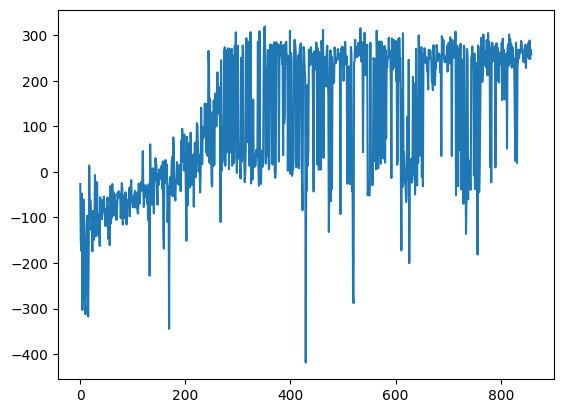

In [7]:
import matplotlib.pyplot as plt

plt.plot(reward_tracker)

In [8]:
torch.save(QNet.state_dict(), "QNet.pth")
torch.save(TargetNet.state_dict(), "TargetNet.pth")

In [9]:
EPISODES = 300
tracker = []
# device = "cuda" if torch.cuda.is_available() else 'cpu'
device = 'cpu'
QNet.eval()
env = gym.make("LunarLander-v3")

with torch.inference_mode():
    for episode in range(EPISODES):
        obs, info = env.reset()
        state = torch.from_numpy(obs).float().unsqueeze(0).to(device)
        done = False
        episode_reward = 0
        while not done:
            action = QNet(state).argmax(1).item()
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
        tracker.append(episode_reward)
        print(f"Episode {episode}, Reward: {episode_reward:.1f}")

Episode 0, Reward: 245.0
Episode 1, Reward: 269.9
Episode 2, Reward: 250.2
Episode 3, Reward: 270.4
Episode 4, Reward: 217.4
Episode 5, Reward: 256.0
Episode 6, Reward: 253.5
Episode 7, Reward: 212.5
Episode 8, Reward: 253.3
Episode 9, Reward: 265.0
Episode 10, Reward: 257.0
Episode 11, Reward: 266.9
Episode 12, Reward: 240.6
Episode 13, Reward: 257.3
Episode 14, Reward: 243.3
Episode 15, Reward: 285.2
Episode 16, Reward: 240.5
Episode 17, Reward: 283.8
Episode 18, Reward: 250.0
Episode 19, Reward: 297.0
Episode 20, Reward: 268.4
Episode 21, Reward: 259.2
Episode 22, Reward: 242.9
Episode 23, Reward: 240.8
Episode 24, Reward: 279.9
Episode 25, Reward: 264.3
Episode 26, Reward: 262.4
Episode 27, Reward: 274.0
Episode 28, Reward: 257.9
Episode 29, Reward: 266.0
Episode 30, Reward: 271.2
Episode 31, Reward: 231.2
Episode 32, Reward: 278.8
Episode 33, Reward: 258.3
Episode 34, Reward: 268.8
Episode 35, Reward: 256.7
Episode 36, Reward: 271.7
Episode 37, Reward: 161.3
Episode 38, Reward: 25

In [10]:
(sum(np.stack(tracker) > 200)/300)*100

np.float64(93.33333333333333)

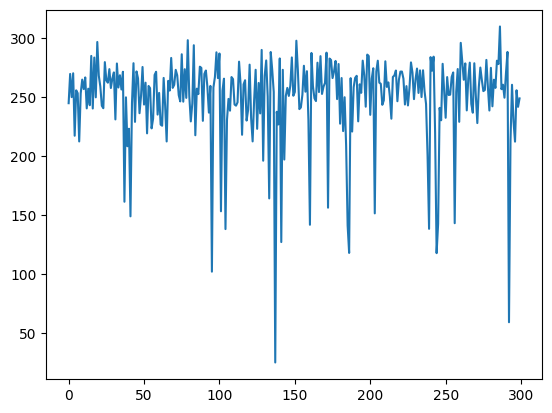

In [11]:
plt.plot(tracker)